# 1. Loading

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import re
import glob
from multiprocessing import Pool, cpu_count
from loguru import logger
import plotly.graph_objects as go
from IPython.display import HTML, display
import collections


paths

In [2]:
# Define the path to aggregated data directory
script_dir = os.path.dirname(os.path.abspath('__file__'))
aggregated_dir = os.path.join(script_dir, '..', '..', 'aggregated')
appended_dir = os.path.join(script_dir, '..', '..', 'appended')
metadata_dir = os.path.join(script_dir, '..', '..', 'metadata')

aggregated data

In [3]:
agg_5min = pd.read_csv(os.path.join(aggregated_dir, 'aggregated_5min.csv'))
agg_15min = pd.read_csv(os.path.join(aggregated_dir, 'aggregated_15min.csv'))

metadata

In [ ]:
metadata = pd.read_csv(os.path.join(metadata_dir, 'Metrics registration.csv'))

raw appended data (for comparison)

In [4]:
original_appended_data = pd.read_csv(os.path.join(appended_dir, 'excl_noon_reports.csv'))

In [12]:
# in the quantity_name column, add a parenthesis with the provider name (if the qid starts with 4) or the unit (if the qid starts with anything else)
original_appended_data['quantity_name'] = original_appended_data.apply(
    lambda row: f"{row['quantity_name']} ({row['source_name']})" if str(row['qid_mapping']).startswith('4') else f"{row['quantity_name']} ({row['unit']})",
    axis=1
)

In [18]:
original_appended_data.head()

,utc_timestamp,qid_mapping,value,quantity_name,source_name,unit,time_delta_sec
0,2024-01-01 00:00:00+00:00,4::0::8::0_1::1::0::7::0_56::0::3::0_8,-0.4000,Vessel External Conditions Eastward Sea Water Velocity (Provider S),Provider S,m/s,NaN
1,2024-01-01 00:00:00+00:00,4::0::4::0_1::1::0::7::0_56::0::4::0_8,0.0000,Vessel External Conditions Northward Sea Water Velocity (Provider MB),Provider MB,m/s,NaN
2,2024-01-01 00:00:00+00:00,4::0::4::0_1::1::0::7::0_45::0::1::0_8,2.7000,Vessel External Conditions Wave Significant Height (Provider MB),Provider MB,m,NaN
3,2024-01-01 00:00:00+00:00,4::0::8::0_1::1::0::7::0_56::0::5::0_8,0.5391,Vessel External Conditions Eastward Wind Velocity (Provider S),Provider S,m/s,NaN
4,2024-01-01 00:00:00+00:00,4::0::4::0_1::1::0::7::0_2::0::15::21_8,79.0000,Vessel External Conditions Wind True Angle (Provider MB),Provider MB,degrees,NaN


In [19]:
agg_15min.head()

,seg_id,window_start,Vessel Hull Over Ground Speed (knots),Vessel Hull Through Water Longitudinal Speed (knots),Vessel External Conditions Wind Relative Speed (knots),Vessel External Conditions Wind Relative Angle (degrees),Vessel Hull Heading True Angle (degrees),Vessel Hull Heading Turn Rate (deg/min),Main Engine Turbocharger Rotational Speed (rpm),Main Engine Scavenging Air Pressure (bar),...,Vessel External Conditions Sea Water Temperature (Provider S),Vessel External Conditions Eastward Sea Water Velocity (Provider MB),Vessel External Conditions Wave Period (Provider S),Vessel External Conditions Wind True Speed (Provider MB),Vessel External Conditions Northward Sea Water Velocity (Provider S),Vessel External Conditions Wave Significant Height (Provider S),Vessel External Conditions Northward Wind Velocity (Provider S),Fwd Draft (Noon Report),Mid Draft (Noon Report),Aft Draft (Noon Report)
0,10,2024-01-04 08:00:00+00:00,12.401552,12.101586,11.754294,325.919954,280.839555,-0.503367,12880.453469,1.493730,...,19.4928,0.00,1.7847,6.36,0.0464,0.1488,4.0150,10.19,10.19,10.19
1,10,2024-01-04 08:15:00+00:00,12.047663,11.757108,11.586808,323.342038,280.867806,-0.167328,12860.939563,1.482888,...,19.4928,0.00,1.7847,6.36,0.0464,0.1488,4.0150,10.19,10.19,10.19
2,10,2024-01-04 08:30:00+00:00,12.104065,12.112681,14.249752,326.192385,281.261508,0.219511,12952.960206,1.513493,...,19.4928,0.00,1.7847,6.36,0.0464,0.1488,4.0150,10.19,10.19,10.19
3,10,2024-01-04 08:45:00+00:00,12.559796,12.478206,15.209066,328.105649,281.005681,-0.020980,13003.071058,1.530807,...,19.4928,0.00,1.7847,6.36,0.0464,0.1488,4.0150,10.19,10.19,10.19
4,10,2024-01-04 09:00:00+00:00,12.015313,11.570251,16.717556,332.168885,280.892922,-0.067982,12935.236188,1.505670,...,19.6822,0.03,1.6988,4.76,0.0702,0.1046,3.7707,10.19,10.19,10.19


In [20]:
metadata.head()

,qid_mapping,quantity_name,source_name,unit
0,3::0::1::0_1::1::0::2::0_11::0::2::0_8,Vessel Hull Aft Draft,Control Alarm Monitoring System,m
1,3::0::1::0_1::1::0::2::0_11::0::1::0_8,Vessel Hull Fore Draft,Control Alarm Monitoring System,m
2,3::0::1::0_1::2::0::8::0_1::0::6::0_8,Main Engine Rotational Speed,Control Alarm Monitoring System,rpm
3,3::0::1::0_1::1::0::2::0_11::0::3::0_8,Vessel Hull MidP Draft,Control Alarm Monitoring System,m
4,3::0::1::0_1::1::0::2::0_11::0::4::0_8,Vessel Hull MidS Draft,Control Alarm Monitoring System,m


In [31]:
# convert utc_timestamp to datetime
agg_5min['window_start'] = pd.to_datetime(agg_5min['window_start'], format='ISO8601', utc=True)
agg_15min['window_start'] = pd.to_datetime(agg_15min['window_start'], format='ISO8601', utc=True)
original_appended_data['utc_timestamp'] = pd.to_datetime(original_appended_data['utc_timestamp'], format='ISO8601', utc=True)

# 2. Initial checks

## 2.1. Distributions

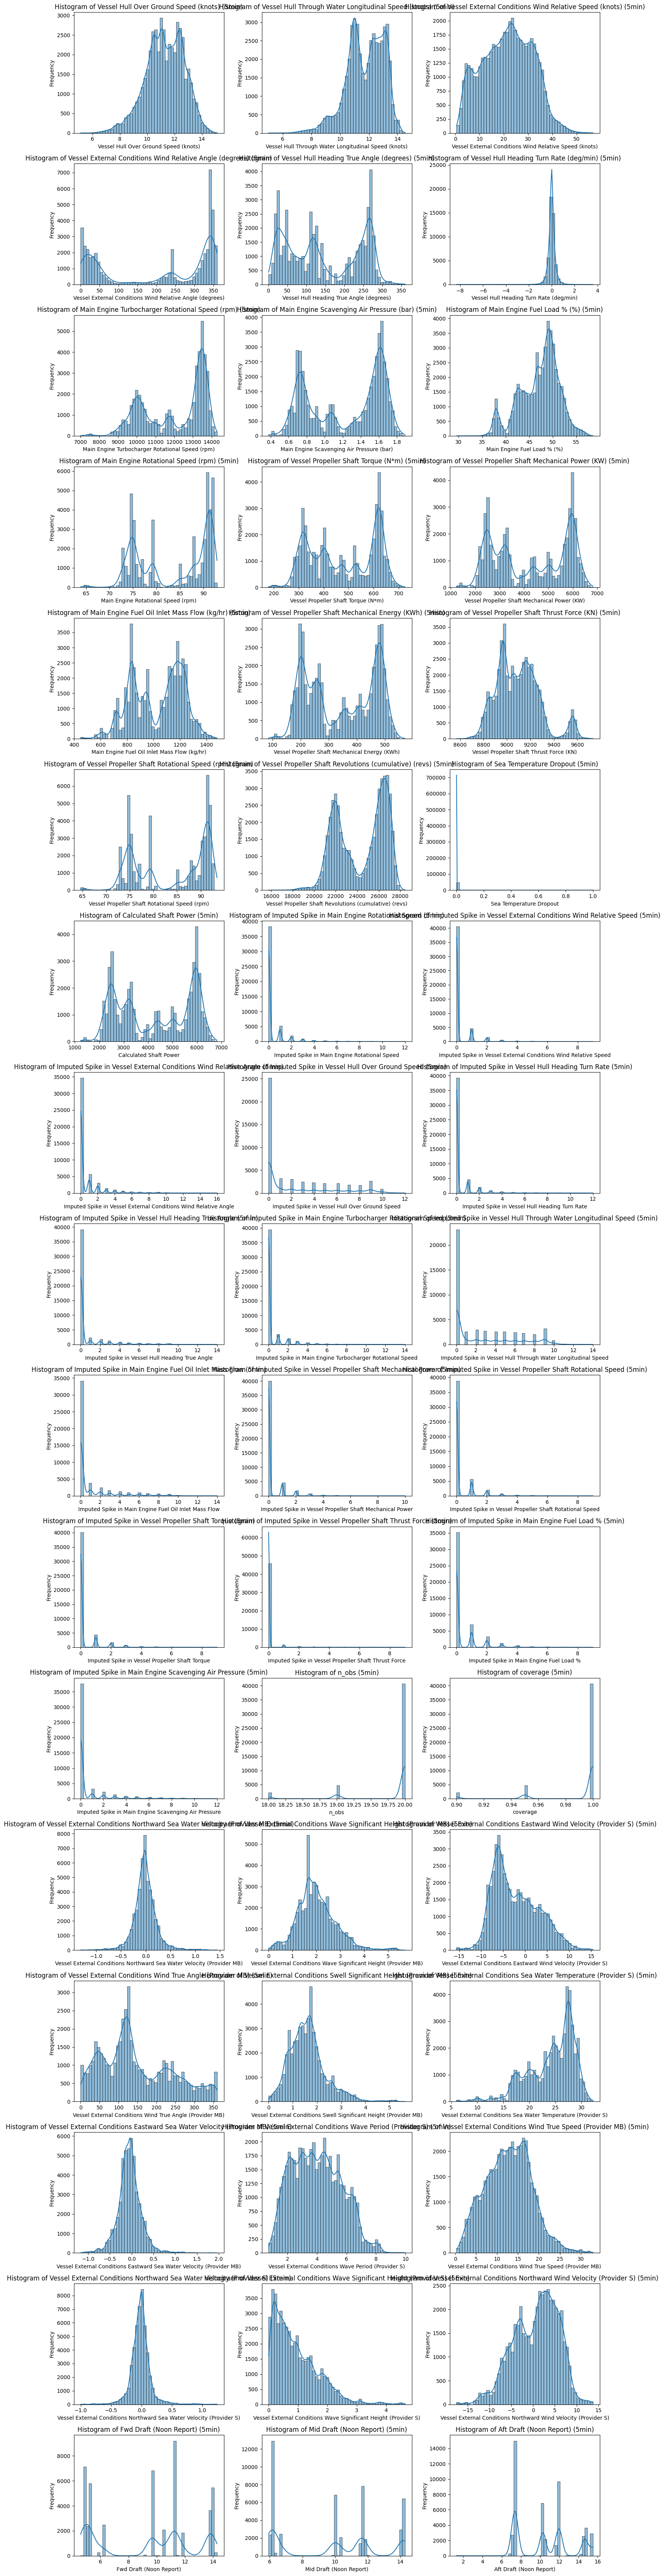

In [8]:
# Make a histogram for each column except window start and seg_id
cols = [col for col in agg_5min.columns if col not in ['window_start', 'seg_id']]
n_cols = 3
n_rows = (len(cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for idx, col in enumerate(cols):
    sns.histplot(agg_5min[col], bins=50, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Histogram of {col} (5min)')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

# Hide unused subplots
for idx in range(len(cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

## 2.2. Line graphs

In [ ]:
def plot_variable_comparison(
    agg_dfs: list[tuple[pd.DataFrame, str]],
    raw_df: pd.DataFrame,
    variable: str,
    start_time: str | pd.Timestamp | None = None,
    end_time: str | pd.Timestamp | None = None,
    ax: plt.Axes | None = None,
    show_legend: bool = False,
) -> plt.Axes:
    # Create axes only if not provided
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 4))

    palette = sns.color_palette("tab10")

    # Normalize time bounds once
    if start_time is not None:
        start_time = pd.to_datetime(start_time, utc=True)
    if end_time is not None:
        end_time = pd.to_datetime(end_time, utc=True)

    # --- Raw data ---
    raw_var = raw_df.loc[raw_df["quantity_name"] == variable, ["utc_timestamp", "value"]]
    if start_time is not None:
        raw_var = raw_var[raw_var["utc_timestamp"] >= start_time]
    if end_time is not None:
        raw_var = raw_var[raw_var["utc_timestamp"] <= end_time]

    ax.plot(
        raw_var["utc_timestamp"], raw_var["value"],
        color=palette[0], linewidth=0.8, alpha=0.5, label="Raw",
    )

    # --- Aggregated data ---
    for i, (agg_df, label) in enumerate(agg_dfs):
        if variable not in agg_df.columns:
            continue

        agg_slice = agg_df.loc[:, ["window_start", variable]].dropna(subset=[variable])

        if start_time is not None:
            agg_slice = agg_slice[agg_slice["window_start"] >= start_time]
        if end_time is not None:
            agg_slice = agg_slice[agg_slice["window_start"] <= end_time]

        ax.plot(
            agg_slice["window_start"], agg_slice[variable],
            color=palette[(i + 1) % len(palette)], linewidth=1.2, label=label,
        )

    ax.set_title(variable, fontsize=9)
    ax.tick_params(axis="x", labelsize=7, labelrotation=30)
    ax.tick_params(axis="y", labelsize=7)

    if show_legend:
        ax.legend(fontsize=7)

    return ax

def plot_variables_grid(
    agg_dfs,
    raw_df,
    variables,
    start_time=None,
    end_time=None,
    n_cols: int = 3,
    row_height: float = 3.5,
    shared_legend: bool = True,
    close: bool = True,   # <- key for "no double display" in notebooks
):
    n = len(variables)
    n_rows = (n + n_cols - 1) // n_cols

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(6 * n_cols, row_height * n_rows),
        squeeze=False,
    )

    for idx, var in enumerate(variables):
        r, c = divmod(idx, n_cols)
        plot_variable_comparison(
            agg_dfs, raw_df, var,
            start_time=start_time, end_time=end_time,
            ax=axes[r][c],
            show_legend=(not shared_legend and idx == 0),
        )

    for idx in range(n, n_rows * n_cols):
        r, c = divmod(idx, n_cols)
        axes[r][c].set_visible(False)

    fig.tight_layout()

    if close:
        plt.close(fig)  # prevents automatic notebook rendering [web:89]

    return fig

In [ ]:
variables_to_plot = original_appended_data['quantity_name'].unique()

start_time = pd.to_datetime("2024-01-05 00:00:00", utc=True)
end_time = pd.to_datetime("2024-01-06 00:00:00", utc=True)

fig = plot_variables_grid(
    agg_dfs = [(agg_5min, '5-min'), (agg_15min, '15-min')],
    raw_df =  original_appended_data,
    variables = variables_to_plot,
    start_time = start_time,
    end_time = end_time,
)

fig

In [ ]:
# TODO: Did i do this correctly? (do the synchronized timeframes match somewhat, do the distributions match)

In [ ]:
# TODO: Derive cleaning events by looking at speed over grond for january and july as well as the following efficiency indicators:
#       - Speed Efficiency Ratio (df['speed_per_power'] = df['Hull Over Ground Speed'] / df['Propeller Shaft Mechanical Power'])
#       - Fuel Consumption vs Speed (df['fuel_per_speed'] = df['Consumption for Propulsion'] / df['Hull Over Ground Speed'])
#       - Power-to-Speed Relationship (Vessel Propeller Shaft Mechanical Power relative to Vessel Hull Over Ground Speed)

# Make a correlation matrix and check that it is as expected

# Make some dummy speed/power curve indications for different drafts

# Matthew: There are some points where the torque doesn’t agree with the power at all when resampling, so I should check my exploration again after resampling
